In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [2]:
import pandas as pd
import numpy as np
from bayesian.train_bn import structure_learning, parameter_learning, parameter_learning_mix
from preprocess.discretization import get_nodes_type, discretization, inverse_discretization, code_categories
from bayesian.save_bn import save_structure, save_params, read_structure, read_params
from external.libpgm.hybayesiannetwork import HyBayesianNetwork
from visualization.visualization import draw_BN
from bayesian.calculate_accuracy import calculate_acc
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from copy import copy
from external.libpgm.sampleaggregator import SampleAggregator
import operator
from sklearn.metrics import accuracy_score, mean_squared_error
from scipy import stats
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture
import math
from pomegranate import DiscreteDistribution
import random
from sklearn.model_selection import train_test_split

In [3]:
df_result_accuracy = pd.DataFrame(columns = ['Parameter', 'Strategy', 'Alg', 'accuracy'])
df_result_rmse = pd.DataFrame(columns = ['Parameter', 'Strategy', 'Alg', 'rmse'])

In [4]:
geo = geo = pd.read_csv('../datasets/hackathon_processed.csv')
columns = ['Tectonic regime', 'Period', 'Lithology', 'Structural setting', 'Hydrocarbon type', 'Gross','Netpay','Porosity','Permeability', 'Depth']
geo = geo[columns]
geo.dropna(inplace=True)
geo.reset_index(inplace=True, drop=True)

In [5]:
geo_train, geo_test = train_test_split(geo, test_size=0.1)
geo_train.reset_index(inplace=True, drop=True)
geo_test.reset_index(inplace=True, drop=True)

In [6]:
geo_types = get_nodes_type(geo)
geo_types

{'Tectonic regime': 'disc',
 'Period': 'disc',
 'Lithology': 'disc',
 'Structural setting': 'disc',
 'Hydrocarbon type': 'disc',
 'Gross': 'cont',
 'Netpay': 'cont',
 'Porosity': 'cont',
 'Permeability': 'cont',
 'Depth': 'cont'}

In [7]:
colums_for_code = []
columns_for_disc = []
for c in columns:
    if geo_types[c] == 'disc':
        colums_for_code.append(c)
    else:
        columns_for_disc.append(c)

In [8]:
geo_coded, label_coder = code_categories(geo_train, 'label', colums_for_code)
geo_discrete, coder = discretization(geo_coded, 'equal_frequency', columns_for_disc)
geo_only_discrete, discrete_coder = discretization(geo_train, 'equal_frequency', columns_for_disc)

# Hill Climbing

# Дискретная структра + смешанные параметры

In [9]:
bn_geo = structure_learning(geo_discrete, 'HC', 'MI', geo_types)

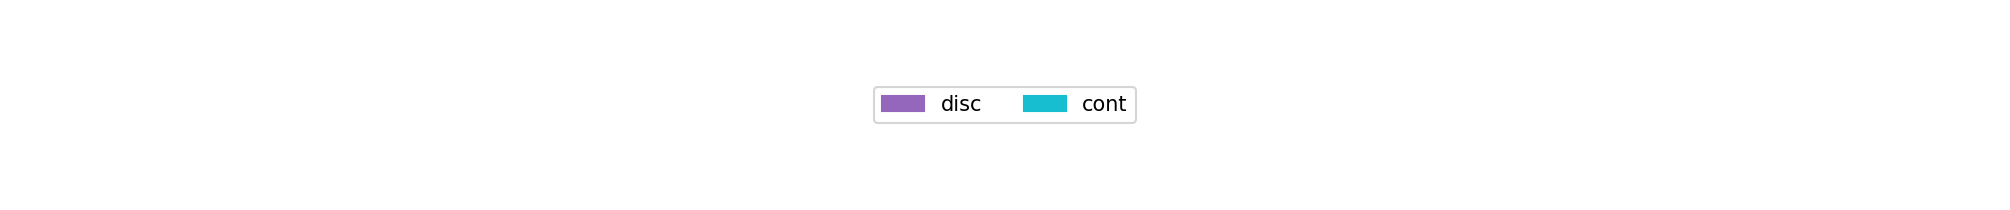

In [10]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [11]:
params = parameter_learning(geo_train, geo_types, bn_geo)

In [12]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [13]:
acc, rmse, real_data, pred_data = calculate_acc(geo_bn, geo_test, columns)

3
6
7
7
11
12
12
13
17
18
21
21
22
22
27
27
29
32
34
35
36
39
42


In [14]:
acc

{'Tectonic regime': 0.58,
 'Period': 0.27,
 'Lithology': 0.51,
 'Structural setting': 0.31,
 'Hydrocarbon type': 0.67}

In [15]:
rmse

{'Gross': 403.23,
 'Netpay': 117.87,
 'Porosity': 4.14,
 'Permeability': 911.19,
 'Depth': 1294.79}

In [16]:
for key in acc.keys():
    df_result_accuracy = df_result_accuracy.append({'Parameter': key, 'Strategy': 'HC', 'Alg':'D+M','accuracy':acc[key]}, ignore_index=True)
for key in rmse.keys():
    df_result_rmse = df_result_rmse.append({'Parameter': key, 'Strategy': 'HC', 'Alg':'D+M','rmse':rmse[key]}, ignore_index=True)

# Смешанная структура + смешанные параметры

In [17]:
bn_geo = structure_learning(geo_coded, 'HC', 'MI', geo_types)

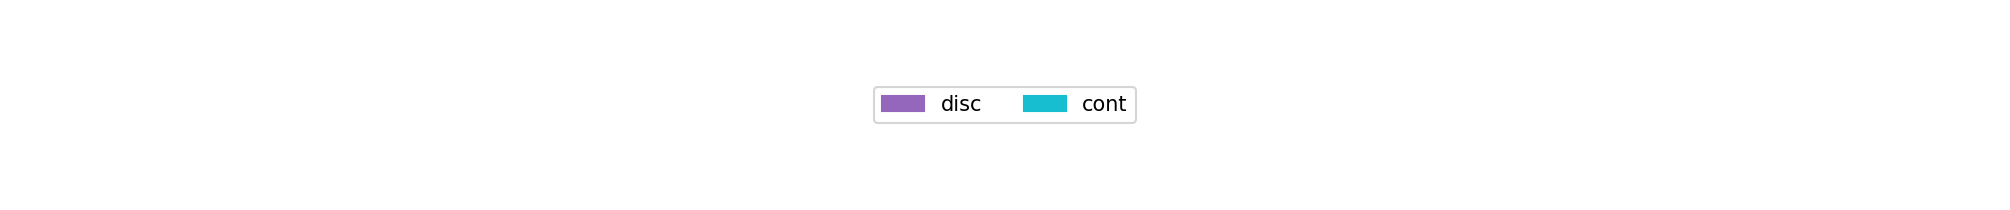

In [18]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [19]:
params = parameter_learning(geo_train, geo_types, bn_geo)

In [20]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [21]:
acc, rmse, real, pred = calculate_acc(geo_bn, geo_test, columns)

3
3
3
3
3
6
6
6
6
6
7
7
7
7
7
7
12
12
12
12
12
12
13
13
13
13
13
18
18
18
18
18
21
21
21
21
21
21
22
22
22
22
22
26
26
26
26
26
27
27
27
27
27
27
32
32
32
32
32
34
34
34
34
34
36
36
36
36
36
42
42
42
42
42


In [22]:
acc

{'Tectonic regime': 0.58,
 'Period': 0.27,
 'Lithology': 0.53,
 'Structural setting': 0.31,
 'Hydrocarbon type': 0.67}

In [23]:
rmse

{'Gross': 265.77,
 'Netpay': 55.15,
 'Porosity': 4.23,
 'Permeability': 488.44,
 'Depth': 831.7}

In [24]:
for key in acc.keys():
    df_result_accuracy = df_result_accuracy.append({'Parameter': key, 'Strategy': 'HC', 'Alg':'M+M','accuracy':acc[key]}, ignore_index=True)
for key in rmse.keys():
    df_result_rmse = df_result_rmse.append({'Parameter': key, 'Strategy': 'HC', 'Alg':'M+M','rmse':rmse[key]}, ignore_index=True)

# Дискретная стурктура + дискретные параметры

In [25]:
geo_new_types = {'Tectonic regime': 'disc',
 'Period': 'disc',
 'Lithology': 'disc',
 'Structural setting': 'disc',
 'Hydrocarbon type': 'disc',
 'Gross': 'disc',
 'Netpay': 'disc',
 'Porosity': 'disc',
 'Permeability': 'disc',
 'Depth': 'disc'}

In [26]:
bn_geo = structure_learning(geo_discrete, 'HC', 'MI', geo_new_types)

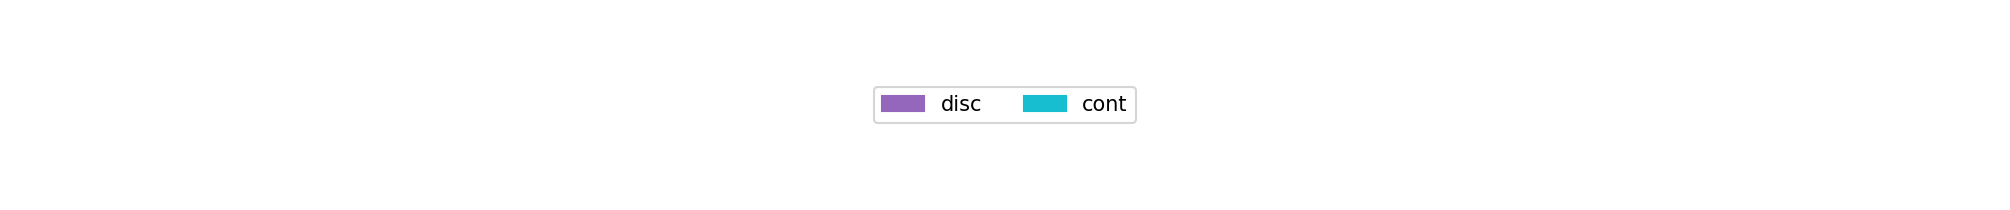

In [27]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [28]:
params = parameter_learning(geo_only_discrete, geo_new_types, bn_geo)

In [29]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [30]:
test_discrete = copy(geo_test)

In [31]:
test_discrete[columns_for_disc] = discrete_coder.transform(geo_test[columns_for_disc].values) 

In [32]:
for c in columns_for_disc:
    test_discrete[c] = test_discrete[c].apply(lambda x: int(x))
test_discrete

,Tectonic regime,Period,Lithology,Structural setting,Hydrocarbon type,Gross,Netpay,Porosity,Permeability,Depth
0,GRAVITY,JURASSIC,LIMESTONE,SALT,OIL,1,2,4,3,2
1,EXTENSION,NEOGENE,SANDSTONE,RIFT,OIL,4,1,4,4,1
2,COMPRESSION,CRETACEOUS,SANDSTONE,FORELAND,OIL,0,0,3,1,1
3,COMPRESSION,PALEOGENE-NEOGENE,LIMESTONE,FORELAND,OIL,4,4,3,2,0
4,GRAVITY,CRETACEOUS,SANDSTONE,SALT,OIL,2,1,4,4,1
5,EXTENSION,PALEOGENE,SANDSTONE,RIFT,OIL,1,1,4,4,1
6,COMPRESSION,ORDOVICIAN,SANDSTONE,INTRACRATONIC,GAS,4,3,0,0,2
7,EXTENSION,MESOZOIC,VOLCANICS,RIFT,OIL,3,3,1,0,4
8,STRIKE-SLIP,NEOGENE,SANDSTONE,INVERSION,OIL,4,3,3,2,1
9,COMPRESSION,CRETACEOUS,LIMESTONE,SALT,OIL,2,2,3,2,1


In [33]:
acc, rmse, real, pred = calculate_acc(geo_bn, test_discrete, columns)

7
7
12
12
21
21
22
22
27
27
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar in

In [34]:
acc

{'Tectonic regime': 0.58,
 'Period': 0.27,
 'Lithology': 0.51,
 'Structural setting': 0.31,
 'Hydrocarbon type': 0.67,
 'Gross': 0.0,
 'Netpay': 0.0,
 'Porosity': 0.0,
 'Permeability': 0.0,
 'Depth': 0.0}

In [35]:
for key in colums_for_code:
    df_result_accuracy = df_result_accuracy.append({'Parameter': key, 'Strategy': 'HC', 'Alg':'D+D','accuracy':acc[key]}, ignore_index=True)

In [36]:
invers_real = inverse_discretization(pd.DataFrame(np.transpose(real[5:10]), columns=['Gross', 'Netpay', 'Porosity', 'Permeability', 'Depth']), ['Gross', 'Netpay', 'Porosity', 'Permeability', 'Depth'], discrete_coder)

In [37]:
invers_pred = inverse_discretization(pd.DataFrame(np.transpose(pred[5:10]), columns=['Gross', 'Netpay', 'Porosity', 'Permeability', 'Depth']), ['Gross', 'Netpay', 'Porosity', 'Permeability', 'Depth'], discrete_coder)

In [38]:
m = mean_squared_error(invers_real['Gross'], invers_pred['Gross'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'Gross', 'Strategy': 'HC', 'Alg':'D+D','rmse':m}, ignore_index=True)

In [39]:
m = mean_squared_error(invers_real['Netpay'], invers_pred['Netpay'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'Netpay', 'Strategy': 'HC', 'Alg':'D+D','rmse':m}, ignore_index=True)

In [40]:
m = mean_squared_error(invers_real['Porosity'], invers_pred['Porosity'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'Porosity', 'Strategy': 'HC', 'Alg':'D+D','rmse':m}, ignore_index=True)

In [41]:
m = mean_squared_error(invers_real['Permeability'], invers_pred['Permeability'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'Permeability', 'Strategy': 'HC', 'Alg':'D+D','rmse':m}, ignore_index=True)

In [42]:
m = mean_squared_error(invers_real['Depth'], invers_pred['Depth'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'Depth', 'Strategy': 'HC', 'Alg':'D+D','rmse':m}, ignore_index=True)

# Смешанная структура + дискретные параметры

In [43]:
bn_geo = structure_learning(geo_coded, 'HC', 'MI', geo_new_types)

ed in double_scalars
  delta1 = -1* nrow * (mi_old - mi_new)
c:\Users\anaxa\Documents\Projects\Mixed-Learning-of-Bayesian-Networks\bayesian\redef_HC.py:258: RuntimeWarning: overflow encountered in double_scalars
  delta2 = nrow * (mi_old - mi_new)
c:\Users\anaxa\Documents\Projects\Mixed-Learning-of-Bayesian-Networks\bayesian\redef_HC.py:178: RuntimeWarning: overflow encountered in double_scalars
  delta_score = nrow * (mi_old - mi_new)
c:\Users\anaxa\Documents\Projects\Mixed-Learning-of-Bayesian-Networks\bayesian\redef_HC.py:178: RuntimeWarning: overflow encountered in double_scalars
  delta_score = nrow * (mi_old - mi_new)
c:\Users\anaxa\Documents\Projects\Mixed-Learning-of-Bayesian-Networks\bayesian\redef_HC.py:178: RuntimeWarning: overflow encountered in double_scalars
  delta_score = nrow * (mi_old - mi_new)
c:\Users\anaxa\Documents\Projects\Mixed-Learning-of-Bayesian-Networks\bayesian\redef_HC.py:178: RuntimeWarning: overflow encountered in double_scalars
  delta_score = nrow * (m

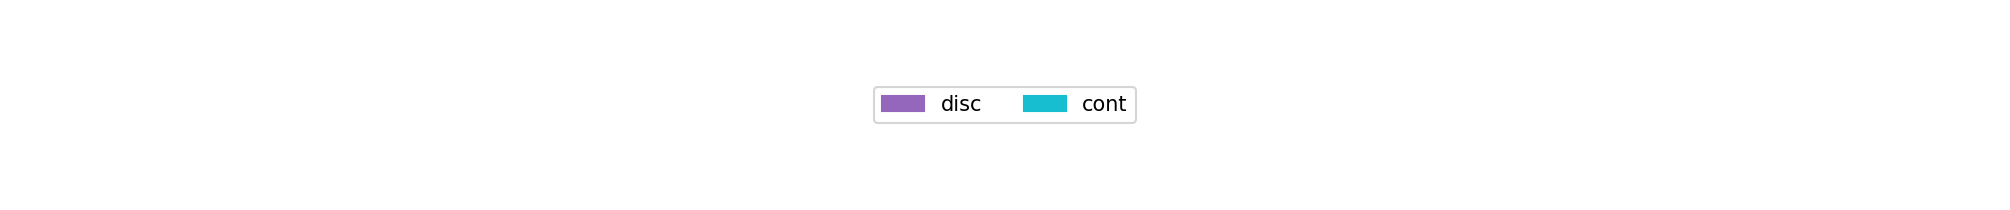

In [44]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [45]:
params = parameter_learning(geo_only_discrete, geo_new_types, bn_geo)

In [46]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [47]:
acc, rmse, real, pred = calculate_acc(geo_bn, test_discrete, columns)

7
7
7
7
7
7
7
12
12
12
12
12
12
12
21
21
21
21
21
21
21
22
22
22
22
22
27
27
27
27
27
27
27
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: F

In [48]:
acc

{'Tectonic regime': 0.58,
 'Period': 0.29,
 'Lithology': 0.53,
 'Structural setting': 0.6,
 'Hydrocarbon type': 0.56,
 'Gross': 0.0,
 'Netpay': 0.0,
 'Porosity': 0.0,
 'Permeability': 0.0,
 'Depth': 0.0}

In [49]:
for key in colums_for_code:
    df_result_accuracy = df_result_accuracy.append({'Parameter': key, 'Strategy': 'HC', 'Alg':'M+D','accuracy':acc[key]}, ignore_index=True)

In [50]:
invers_real = inverse_discretization(pd.DataFrame(np.transpose(real[5:10]), columns=['Gross', 'Netpay', 'Porosity', 'Permeability', 'Depth']), ['Gross', 'Netpay', 'Porosity', 'Permeability', 'Depth'], discrete_coder)

In [51]:
invers_pred = inverse_discretization(pd.DataFrame(np.transpose(pred[5:10]), columns=['Gross', 'Netpay', 'Porosity', 'Permeability', 'Depth']), ['Gross', 'Netpay', 'Porosity', 'Permeability', 'Depth'], discrete_coder)

In [52]:
mean_squared_error(invers_real['Gross'], invers_pred['Gross'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'Gross', 'Strategy': 'HC', 'Alg':'M+D','rmse':mean_squared_error(invers_real['Gross'], invers_pred['Gross'], squared=False)}, ignore_index=True)

In [53]:
mean_squared_error(invers_real['Netpay'], invers_pred['Netpay'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'Netpay', 'Strategy': 'HC', 'Alg':'M+D','rmse':mean_squared_error(invers_real['Netpay'], invers_pred['Netpay'], squared=False)}, ignore_index=True)

In [54]:
mean_squared_error(invers_real['Porosity'], invers_pred['Porosity'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'Porosity', 'Strategy': 'HC', 'Alg':'M+D','rmse':mean_squared_error(invers_real['Porosity'], invers_pred['Porosity'], squared=False)}, ignore_index=True)

In [55]:
mean_squared_error(invers_real['Permeability'], invers_pred['Permeability'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'Permeability', 'Strategy': 'HC', 'Alg':'M+D','rmse':mean_squared_error(invers_real['Permeability'], invers_pred['Permeability'], squared=False)}, ignore_index=True)

In [56]:
mean_squared_error(invers_real['Depth'], invers_pred['Depth'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'Depth', 'Strategy': 'HC', 'Alg':'M+D','rmse':mean_squared_error(invers_real['Depth'], invers_pred['Depth'], squared=False)}, ignore_index=True)

# EVO

# Дискретная стурктура + смешанные параметры

In [57]:
bn_geo = structure_learning(geo_discrete, 'evo', 'MI', geo_types)

Cannot add to history: 'str' object has no attribute 'operation_type'
Best metric is 13.092799999999999
Generation num: 0
max_depth: 3, no improvements: 0
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.1 min
Best metric is 11.6002
Generation num: 1
max_depth: 3, no improvements: 0
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.1 min
Best metric is 11.5975
Generation num: 2
max_depth: 3, no improvements: 0
Number of mutation attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.1 min
Best metric is 11.149700000000001
Generation num: 3
max_depth: 3, no improvements: 0
Number of mutation attempts exceeded. Please check composer requiremen

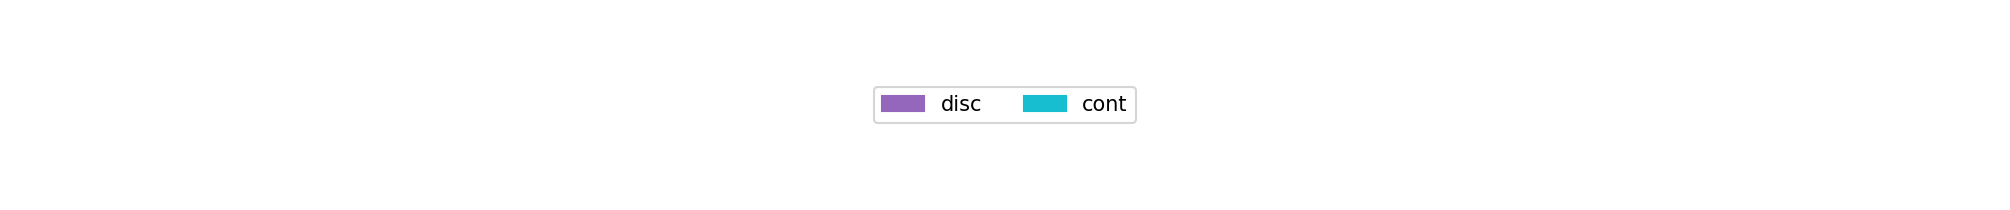

In [58]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [59]:
params = parameter_learning(geo_train, geo_types, bn_geo)

In [60]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [61]:
acc, rmse, real_data, pred_data = calculate_acc(geo_bn, geo_test, columns)

7
12
21
27
36


In [62]:
acc

{'Tectonic regime': 0.58,
 'Period': 0.27,
 'Lithology': 0.51,
 'Structural setting': 0.56,
 'Hydrocarbon type': 0.67}

In [63]:
rmse

{'Gross': 401.05,
 'Netpay': 124.06,
 'Porosity': 6.42,
 'Permeability': 726.17,
 'Depth': 1300.66}

In [64]:
for key in acc.keys():
    df_result_accuracy = df_result_accuracy.append({'Parameter': key, 'Strategy': 'evo', 'Alg':'D+M','accuracy':acc[key]}, ignore_index=True)
for key in rmse.keys():
    df_result_rmse = df_result_rmse.append({'Parameter': key, 'Strategy': 'evo', 'Alg':'D+M','rmse':rmse[key]}, ignore_index=True)

# Смешанная структура + смешанные параметры

In [65]:
bn_geo = structure_learning(geo_coded, 'evo', 'MI', geo_types)

Cannot add to history: 'str' object has no attribute 'operation_type'
Best metric is 24.409237732838285
Generation num: 0
max_depth: 3, no improvements: 0
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.2 min
Best metric is 24.409237732838285
Generation num: 1
max_depth: 3, no improvements: 1
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.2 min
Best metric is 24.409237732838285
Generation num: 2
max_depth: 3, no improvements: 2
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.3 min
Best metric is 24.409237732838285
Generation num: 3
max_depth: 3, no improvements: 3
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.5 min
Best metric is 20.26398575676989
Generation num:

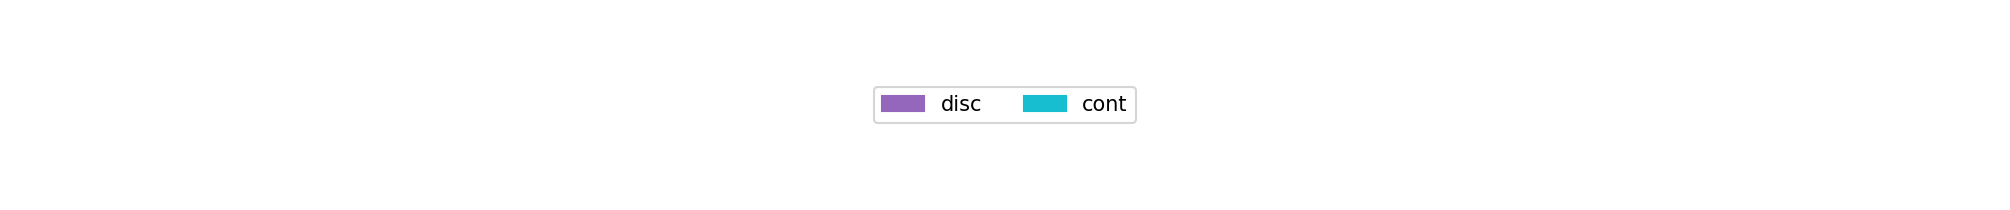

In [66]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [67]:
params = parameter_learning(geo_train, geo_types, bn_geo)

In [68]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [69]:
acc, rmse, real, pred = calculate_acc(geo_bn, geo_test, columns)

7
22
29
34
36


In [70]:
acc

{'Tectonic regime': 0.58,
 'Period': 0.27,
 'Lithology': 0.51,
 'Structural setting': 0.31,
 'Hydrocarbon type': 0.67}

In [71]:
rmse

{'Gross': 417.6,
 'Netpay': 93.77,
 'Porosity': 7.57,
 'Permeability': 877.12,
 'Depth': 1253.64}

In [72]:
for key in acc.keys():
    df_result_accuracy = df_result_accuracy.append({'Parameter': key, 'Strategy': 'evo', 'Alg':'M+M','accuracy':acc[key]}, ignore_index=True)
for key in rmse.keys():
    df_result_rmse = df_result_rmse.append({'Parameter': key, 'Strategy': 'evo', 'Alg':'M+M','rmse':rmse[key]}, ignore_index=True)

# Дискретная структура + дискретные параметры

In [73]:
geo_new_types = {'Tectonic regime': 'disc',
 'Period': 'disc',
 'Lithology': 'disc',
 'Structural setting': 'disc',
 'Hydrocarbon type': 'disc',
 'Gross': 'disc',
 'Netpay': 'disc',
 'Porosity': 'disc',
 'Permeability': 'disc',
 'Depth': 'disc'}

In [74]:
bn_geo = structure_learning(geo_discrete, 'evo', 'MI', geo_new_types)

Cannot add to history: 'str' object has no attribute 'operation_type'
Best metric is 11.737200000000001
Generation num: 0
max_depth: 3, no improvements: 0
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.1 min
Best metric is 11.245600000000001
Generation num: 1
max_depth: 3, no improvements: 0
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.1 min
Best metric is 10.3696
Generation num: 2
max_depth: 3, no improvements: 0
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.1 min
Best metric is 10.3696
Generation num: 3
max_depth: 3, no improvements: 1
Number of mutation attempts exceeded. Please check composer requirements for correctness.
Number of mutation attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has no attribute 'operation_type'
s

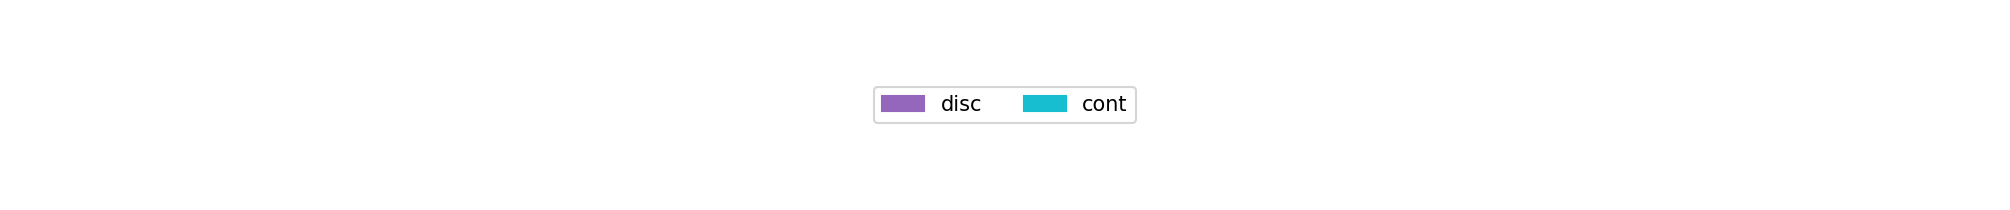

In [75]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [76]:
params = parameter_learning(geo_only_discrete, geo_new_types, bn_geo)

In [77]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [78]:
acc, rmse, real, pred = calculate_acc(geo_bn, test_discrete, columns)

7
12
21
22
27
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in 

In [79]:
acc

{'Tectonic regime': 0.58,
 'Period': 0.27,
 'Lithology': 0.51,
 'Structural setting': 0.27,
 'Hydrocarbon type': 0.67,
 'Gross': 0.0,
 'Netpay': 0.0,
 'Porosity': 0.0,
 'Permeability': 0.0,
 'Depth': 0.0}

In [80]:
for key in colums_for_code:
    df_result_accuracy = df_result_accuracy.append({'Parameter': key, 'Strategy': 'evo', 'Alg':'D+D','accuracy':acc[key]}, ignore_index=True)

In [81]:
invers_real = inverse_discretization(pd.DataFrame(np.transpose(real[5:10]), columns=['Gross', 'Netpay', 'Porosity', 'Permeability', 'Depth']), ['Gross', 'Netpay', 'Porosity', 'Permeability', 'Depth'], discrete_coder)

In [82]:
invers_pred = inverse_discretization(pd.DataFrame(np.transpose(pred[5:10]), columns=['Gross', 'Netpay', 'Porosity', 'Permeability', 'Depth']), ['Gross', 'Netpay', 'Porosity', 'Permeability', 'Depth'], discrete_coder)

In [83]:
mean_squared_error(invers_real['Gross'], invers_pred['Gross'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'Gross', 'Strategy': 'evo', 'Alg':'D+D','rmse':mean_squared_error(invers_real['Gross'], invers_pred['Gross'], squared=False)}, ignore_index=True)

In [84]:
mean_squared_error(invers_real['Netpay'], invers_pred['Netpay'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'Netpay', 'Strategy': 'evo', 'Alg':'D+D','rmse':mean_squared_error(invers_real['Netpay'], invers_pred['Netpay'], squared=False)}, ignore_index=True)

In [85]:
mean_squared_error(invers_real['Porosity'], invers_pred['Porosity'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'Porosity', 'Strategy': 'evo', 'Alg':'D+D','rmse':mean_squared_error(invers_real['Porosity'], invers_pred['Porosity'], squared=False)}, ignore_index=True)


In [86]:
mean_squared_error(invers_real['Permeability'], invers_pred['Permeability'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'Permeability', 'Strategy': 'evo', 'Alg':'D+D','rmse':mean_squared_error(invers_real['Permeability'], invers_pred['Permeability'], squared=False)}, ignore_index=True)

In [87]:
mean_squared_error(invers_real['Depth'], invers_pred['Depth'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'Depth', 'Strategy': 'evo', 'Alg':'D+D','rmse':mean_squared_error(invers_real['Depth'], invers_pred['Depth'], squared=False)}, ignore_index=True)

# Смешанная структура + дискретные параметры

In [88]:
bn_geo = structure_learning(geo_coded, 'evo', 'MI', geo_new_types)

Cannot add to history: 'str' object has no attribute 'operation_type'
Best metric is 31.726026408575642
Generation num: 0
max_depth: 3, no improvements: 0
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.2 min
Best metric is 25.936803376070102
Generation num: 1
max_depth: 3, no improvements: 0
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.3 min
Best metric is 25.936803376070102
Generation num: 2
max_depth: 3, no improvements: 1
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.5 min
Best metric is 24.871221831345135
Generation num: 3
max_depth: 3, no improvements: 0
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.5 min
Best metric is 23.73784127662323
Generation num:

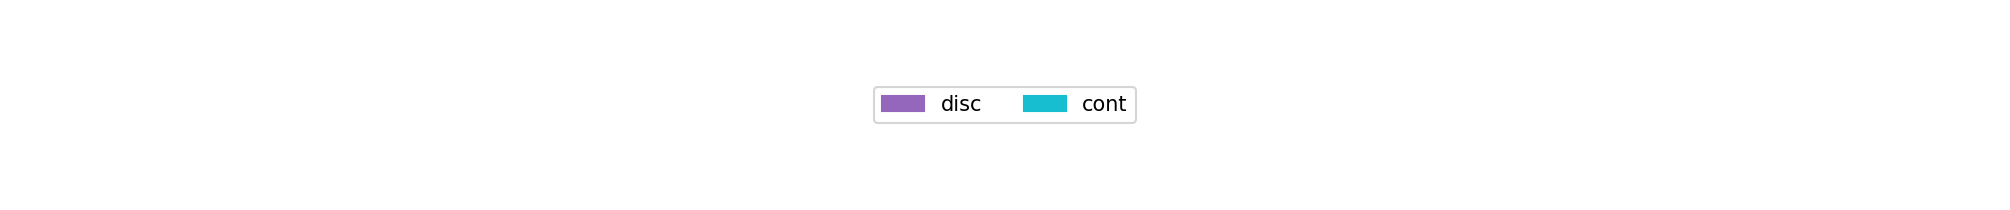

In [89]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [90]:
params = parameter_learning(geo_only_discrete, geo_new_types, bn_geo)

In [91]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [92]:
acc, rmse, real, pred = calculate_acc(geo_bn, test_discrete, columns)

22
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future 

In [93]:
acc

{'Tectonic regime': 0.58,
 'Period': 0.27,
 'Lithology': 0.51,
 'Structural setting': 0.31,
 'Hydrocarbon type': 0.67,
 'Gross': 0.0,
 'Netpay': 0.0,
 'Porosity': 0.0,
 'Permeability': 0.0,
 'Depth': 0.0}

In [94]:
for key in colums_for_code:
    df_result_accuracy = df_result_accuracy.append({'Parameter': key, 'Strategy': 'evo', 'Alg':'M+D','accuracy':acc[key]}, ignore_index=True)

In [95]:
invers_real = inverse_discretization(pd.DataFrame(np.transpose(real[5:10]), columns=['Gross', 'Netpay', 'Porosity', 'Permeability', 'Depth']), ['Gross', 'Netpay', 'Porosity', 'Permeability', 'Depth'], discrete_coder)


In [96]:
invers_pred = inverse_discretization(pd.DataFrame(np.transpose(pred[5:10]), columns=['Gross', 'Netpay', 'Porosity', 'Permeability', 'Depth']), ['Gross', 'Netpay', 'Porosity', 'Permeability', 'Depth'], discrete_coder)

In [97]:
mean_squared_error(invers_real['Gross'], invers_pred['Gross'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'Gross', 'Strategy': 'evo', 'Alg':'M+D','rmse':mean_squared_error(invers_real['Gross'], invers_pred['Gross'], squared=False)}, ignore_index=True)

In [98]:
mean_squared_error(invers_real['Netpay'], invers_pred['Netpay'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'Netpay', 'Strategy': 'evo', 'Alg':'M+D','rmse':mean_squared_error(invers_real['Netpay'], invers_pred['Netpay'], squared=False)}, ignore_index=True)

In [99]:
mean_squared_error(invers_real['Porosity'], invers_pred['Porosity'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'Porosity', 'Strategy': 'evo', 'Alg':'M+D','rmse':mean_squared_error(invers_real['Porosity'], invers_pred['Porosity'], squared=False)}, ignore_index=True)

In [100]:
mean_squared_error(invers_real['Permeability'], invers_pred['Permeability'], squared=False)
df_result_rmse = df_result_rmse = df_result_rmse.append({'Parameter': 'Permeability', 'Strategy': 'evo', 'Alg':'M+D','rmse':mean_squared_error(invers_real['Permeability'], invers_pred['Permeability'], squared=False)}, ignore_index=True)

In [101]:
mean_squared_error(invers_real['Depth'], invers_pred['Depth'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'Depth', 'Strategy': 'evo', 'Alg':'M+D','rmse':mean_squared_error(invers_real['Depth'], invers_pred['Depth'], squared=False)}, ignore_index=True)

In [102]:
df_result_accuracy.to_csv('geo_results_disc.csv', index=False)
df_result_rmse.to_csv('geo_results_cont.csv', index=False)